In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

from tabulate import tabulate

from sklearn import linear_model
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import re
from sklearn.metrics import silhouette_score

from sklearn.cluster import DBSCAN
import hdbscan

from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from yellowbrick.cluster import SilhouetteVisualizer
import plotly
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('Seattle_cleaned_data.csv').drop("Unnamed: 0",axis=1)
df.head(2)

id                          listing_url       scrape_id last_scraped  \
0  241032  https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1  953595  https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   

                                 name  \
0        Stylish Queen Anne Apartment   
1  Bright & Airy Queen Anne Apartment   

                                             summary  \
0                           No Information Available   
1  Chemically sensitive? We've removed the irrita...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   

                                         description  \
0  Make your self at home in this charming one-be...   
1  Chemically sensitive? We've removed the irrita...   

                               neighborhood_overview  \
0                           No Information Available   
1  Queen Anne is a wonderful, truly functional vi...   

                                               notes  ...  \
0                           No Information Available  ...   
1  What's up with the free pillows?  Our home was...  ...   

  review_scores_location review_scores_value requires_license  \
0                    9.0                10.0                0   
1                   10.0                10.0                0   

  jurisdiction_names instant_bookable  cancellation_policy  \
0         WASHINGTON                0             moderate   
1         WASHINGTON                0               strict   

  require_guest_profile_picture require_guest_phone_verification  \
0                             0                                0   
1                             1                                1   

  calculated_host_listings_count reviews_per_month  
0                              2              4.07  
1                              6              1.48  

[2 rows x 89 columns]

<h5>Calculating "hosting_experience" by subtracting 'host_since' date  from 'last_scraped' date

In [3]:
df['host_since'] = pd.to_datetime(df['host_since'])
df['last_scraped'] = pd.to_datetime(df['last_scraped'])
df["hosting_experience"]= df['last_scraped'] - df['host_since']

<h5>Calculating Average review score on the properties of a host

In [4]:
host_review=pd.DataFrame(df.groupby(by= "host_id")["review_scores_rating"].mean()/100)
host_review.reset_index(inplace=True)

In [5]:
df = pd.merge(df,host_review,on='host_id', how='left')

In [6]:
df.head(2)

id                          listing_url       scrape_id last_scraped  \
0  241032  https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1  953595  https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   

                                 name  \
0        Stylish Queen Anne Apartment   
1  Bright & Airy Queen Anne Apartment   

                                             summary  \
0                           No Information Available   
1  Chemically sensitive? We've removed the irrita...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   

                                         description  \
0  Make your self at home in this charming one-be...   
1  Chemically sensitive? We've removed the irrita...   

                               neighborhood_overview  \
0                           No Information Available   
1  Queen Anne is a wonderful, truly functional vi...   

                                               notes  ... requires_license  \
0                           No Information Available  ...                0   
1  What's up with the free pillows?  Our home was...  ...                0   

  jurisdiction_names instant_bookable cancellation_policy  \
0         WASHINGTON                0            moderate   
1         WASHINGTON                0              strict   

  require_guest_profile_picture  require_guest_phone_verification  \
0                             0                                 0   
1                             1                                 1   

  calculated_host_listings_count reviews_per_month hosting_experience  \
0                              2              4.07          1607 days   
1                              6              1.48          1047 days   

  review_scores_rating_y  
0               0.900000  
1               0.966667  

[2 rows x 91 columns]

<h5/>To categorize the hosts the following features are seemed to be relevant: </h5>

    <li/> host_id - Unique identification for each host.
    <li> hosting_experience - Number of days since when he/she has started hosting.
    <li> host_response_time - Average time takenng by the host to respond against any querry by customer.
            1 - Responds with in an hour.
            6 - Responds with in few hours.
            24 - Responds with in a day.
            72 - Responds with in a few days or more.
            96 - Responds rarely.
            
    <li> host_response_rate - The rate at which the host responds.
    <li> host_acceptance_rate - That rate at which a host accepts booking requests.
    <li> host_is_superhost - Whether the host is very active or not.
            1- Yes
            0- No
    <li> host_verifications - Number of verifications done by the host.
    <li> host_has_profile_pic - Whether the host has provided their profile picture or not.
            1- Yes
            0- No
    <li> host_identity_verified - Whether the host's identity is verified or not.
            1- Yes
            0- No
    <li> calculated_host_listings_count - Total number of properties the host possessess for renting.
  
            
    

In [7]:
cols = ['host_id', 'hosting_experience','host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'calculated_host_listings_count','cancellation_policy',"review_scores_rating_y"]

In [8]:
df_host = df.loc[:,cols]

In [9]:
df_host.shape

(3802, 12)

<h5>Converting hosting experience as Integers from Date-time data type

In [10]:
def days_to_int(x):
    return int(re.findall("\d+",str(x))[0])

In [11]:
df_host['hosting_experience'] = df_host['hosting_experience'].apply(days_to_int)

In [12]:
df_host.head(1)

host_id  hosting_experience  host_response_time  host_response_rate  \
0   956883                1607                   6                0.96   

   host_acceptance_rate  host_is_superhost  \
0                   1.0                  0   

                     host_verifications  host_has_profile_pic  \
0  ['email', 'phone', 'reviews', 'kba']                     1   

   host_identity_verified  calculated_host_listings_count cancellation_policy  \
0                       1                               2            moderate   

   review_scores_rating_y  
0                     0.9

In [13]:
df_host.head(1)

host_id  hosting_experience  host_response_time  host_response_rate  \
0   956883                1607                   6                0.96   

   host_acceptance_rate  host_is_superhost  \
0                   1.0                  0   

                     host_verifications  host_has_profile_pic  \
0  ['email', 'phone', 'reviews', 'kba']                     1   

   host_identity_verified  calculated_host_listings_count cancellation_policy  \
0                       1                               2            moderate   

   review_scores_rating_y  
0                     0.9

In [14]:
def str_to_list(x):
    return len(re.findall("[a-z]+",x))
df_host['host_verifications'] = df_host['host_verifications'].apply(str_to_list)

In [15]:
df_host.head(1)

host_id  hosting_experience  host_response_time  host_response_rate  \
0   956883                1607                   6                0.96   

   host_acceptance_rate  host_is_superhost  host_verifications  \
0                   1.0                  0                   4   

   host_has_profile_pic  host_identity_verified  \
0                     1                       1   

   calculated_host_listings_count cancellation_policy  review_scores_rating_y  
0                               2            moderate                     0.9

<h5> As single host has more than one listings in the given dataset. Therefore we are deleting the duplicate entries for each host. 

In [16]:
df_host=df_host.sort_values(by= "host_id").drop_duplicates(keep='first')
df_host=df_host.sort_values(by= "host_id").drop_duplicates(subset="host_id")

In [17]:
df_host.head()

host_id  hosting_experience  host_response_time  host_response_rate  \
2180     4193                2611                   6                0.88   
1405     6207                2552                   1                1.00   
3005     8021                2513                   6                0.75   
2155     8993                2498                   1                1.00   
2230    11775                2471                   6                1.00   

      host_acceptance_rate  host_is_superhost  host_verifications  \
2180                   1.0                  0                   5   
1405                   1.0                  1                   6   
3005                   1.0                  0                   6   
2155                   1.0                  0                   4   
2230                   1.0                  0                   5   

      host_has_profile_pic  host_identity_verified  \
2180                     1                       1   
1405                     1                       1   
3005                     1                       1   
2155                     1                       1   
2230                     1                       1   

      calculated_host_listings_count cancellation_policy  \
2180                               4              strict   
1405                               1              strict   
3005                               1            flexible   
2155                               1              strict   
2230                               1            moderate   

      review_scores_rating_y  
2180                0.896667  
1405                0.960000  
3005                0.965000  
2155                0.960000  
2230                0.950000

In [18]:
df_host.host_response_rate.nunique()

45

<h3>There are total 2739 number of hosts are present in Seattle

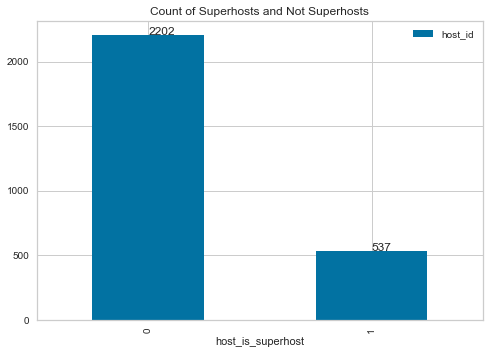

In [19]:
ax=df_host.pivot_table(index="host_is_superhost",values= "host_id",aggfunc="count" ).plot(kind="bar")
for bar in ax.patches:
    y= bar.get_height()
    x= bar.get_x()+ bar.get_width()/2
    plt.text(x,y,y)
plt.title("Count of Superhosts and Not Superhosts")
plt.show()

<h5>75% of the hosts are not Superhosts.

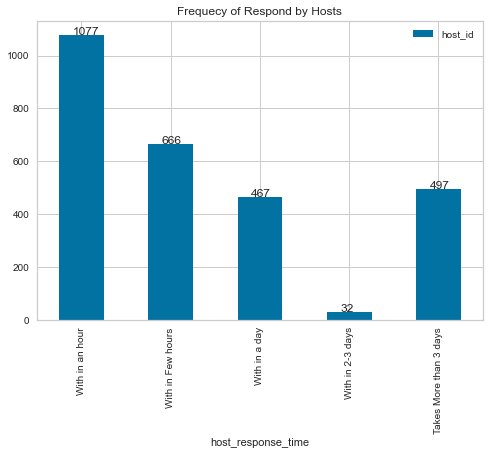

In [20]:
ax=df_host.pivot_table(index="host_response_time",values= "host_id",aggfunc="count" ).plot(kind="bar")
for bar in ax.patches:
    y= bar.get_height()
    x= bar.get_x()+ bar.get_width()/2-0.1
    plt.text(x,y,y)
plt.title("Frequecy of Respond by Hosts")
ax.set_xticklabels(["With in an hour","With in Few hours", "With in a day", "With in 2-3 days",  "Takes More than 3 days"])
plt.show()

<h5> Majority of the hosts responds with in a hour

<h5> Identifying Categorical Columns and Continuous Columns

In [21]:
def cat_or_cont(df):
    cat=[]
    cont=[]
    for col in df.keys():
        if df[col].nunique() >10:
            cont.append(col)
        else:
            cat.append(col)
    print(tabulate({"Categorical":cat,"Continuous":cont},headers="keys"))
    return cat

In [22]:
cat = cat_or_cont(df_host)

Categorical             Continuous
----------------------  ------------------------------
host_response_time      host_id
host_acceptance_rate    hosting_experience
host_is_superhost       host_response_rate
host_has_profile_pic    host_verifications
host_identity_verified  calculated_host_listings_count
cancellation_policy     review_scores_rating_y


In [23]:
df_host.head(2)

host_id  hosting_experience  host_response_time  host_response_rate  \
2180     4193                2611                   6                0.88   
1405     6207                2552                   1                1.00   

      host_acceptance_rate  host_is_superhost  host_verifications  \
2180                   1.0                  0                   5   
1405                   1.0                  1                   6   

      host_has_profile_pic  host_identity_verified  \
2180                     1                       1   
1405                     1                       1   

      calculated_host_listings_count cancellation_policy  \
2180                               4              strict   
1405                               1              strict   

      review_scores_rating_y  
2180                0.896667  
1405                0.960000

In [24]:
df_host=df_host.reset_index()

In [25]:
df_host["Response_score"] = df_host["host_response_rate"]/df_host["host_response_time"]

In [26]:
df_host["verification_score"] = (df_host["host_verifications"]/df_host["host_verifications"].max())*0.45 + df_host["host_has_profile_pic"]*0.15 + df_host["host_identity_verified"]*0.4

In [27]:
df_host["verification_score"].unique()

array([0.775, 0.82 , 0.73 , 0.285, 0.24 , 0.33 , 0.91 , 0.18 , 0.865,
       0.375, 0.955, 1.   , 0.42 , 0.685, 0.225, 0.195, 0.09 , 0.27 ,
       0.   ])

In [28]:
df_host["Hosting_Score"] = df_host["host_acceptance_rate"]*0.20 + df_host["host_is_superhost"]*0.35 + (df_host["calculated_host_listings_count"]/df_host["calculated_host_listings_count"].max())*0.1+(df_host["hosting_experience"]/df_host["hosting_experience"].max())*0.35 

In [29]:
df_host.head()

index  host_id  hosting_experience  host_response_time  host_response_rate  \
0   2180     4193                2611                   6                0.88   
1   1405     6207                2552                   1                1.00   
2   3005     8021                2513                   6                0.75   
3   2155     8993                2498                   1                1.00   
4   2230    11775                2471                   6                1.00   

   host_acceptance_rate  host_is_superhost  host_verifications  \
0                   1.0                  0                   5   
1                   1.0                  1                   6   
2                   1.0                  0                   6   
3                   1.0                  0                   4   
4                   1.0                  0                   5   

   host_has_profile_pic  host_identity_verified  \
0                     1                       1   
1                     1                       1   
2                     1                       1   
3                     1                       1   
4                     1                       1   

   calculated_host_listings_count cancellation_policy  review_scores_rating_y  \
0                               4              strict                0.896667   
1                               1              strict                0.960000   
2                               1            flexible                0.965000   
3                               1              strict                0.960000   
4                               1            moderate                0.950000   

   Response_score  verification_score  Hosting_Score  
0        0.146667               0.775       0.560811  
1        1.000000               0.820       0.894794  
2        0.125000               0.820       0.539566  
3        1.000000               0.730       0.537555  
4        0.166667               0.775       0.533936

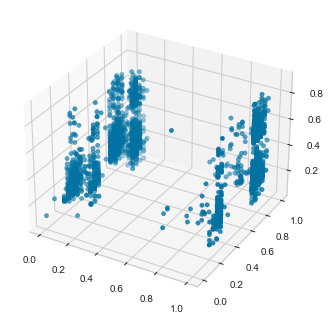

In [30]:
ax = plt.axes(projection ="3d")
ax.scatter3D(df_host.Response_score, df_host.verification_score, df_host.Hosting_Score)

In [31]:
X= df_host[["Response_score", "verification_score", "Hosting_Score"]]

<h5>Identifying Number of Clusters by Elbow Method and Silhouette Score

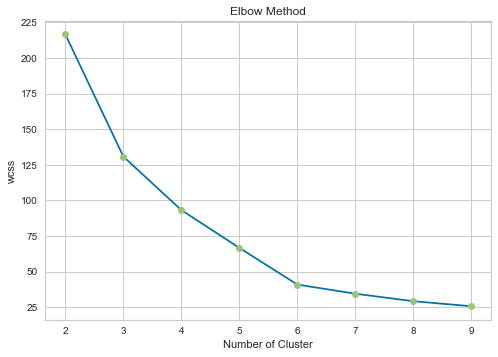

In [32]:
wcss=[]
r= range(2,10)

for i in r:
    kmeans = KMeans(n_clusters = i, init = 'k-means++',n_init=100,random_state=101)
    kmeans.fit (df_host[["Response_score", "verification_score", "Hosting_Score"]])
    wcss.append(kmeans.inertia_)
    
plt.plot(r,wcss)
plt.plot(r,wcss,"o")
plt.xlabel("Number of Cluster")
plt.ylabel("wcss")
plt.title("Elbow Method")
plt.show()

<p><font color="green"><b>In the above picture, you can see the elbow point, which is 6. After that point, WSS is almost constant. So 6 is selected as K.In this way elbow method is used for finding the value of K.

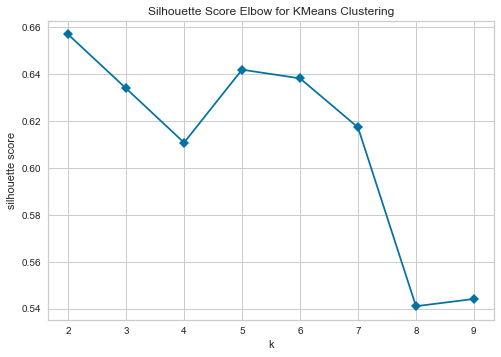

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [33]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10),metric="silhouette", timings= False,locate_elbow=False)
visualizer.fit(df_host[["Response_score", "verification_score", "Hosting_Score"]])     
visualizer.show() 

<p><font color="green"><b>From the Silhouette Score elbow we can see that elbow is wither on k=2, k=5 or k=6

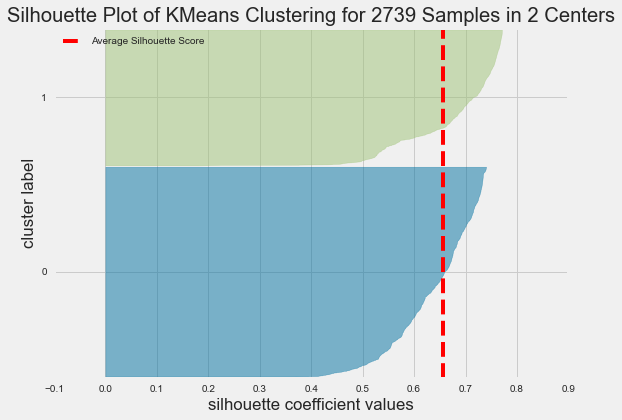

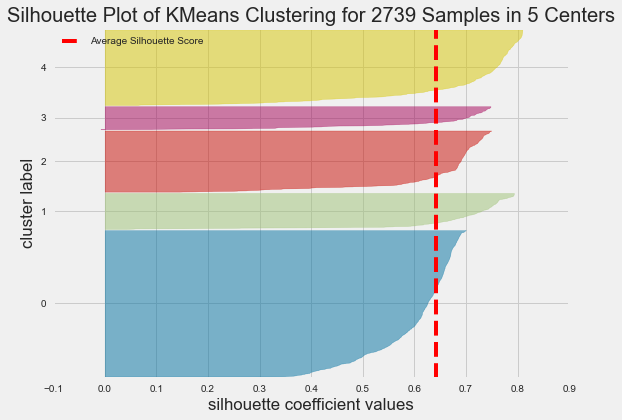

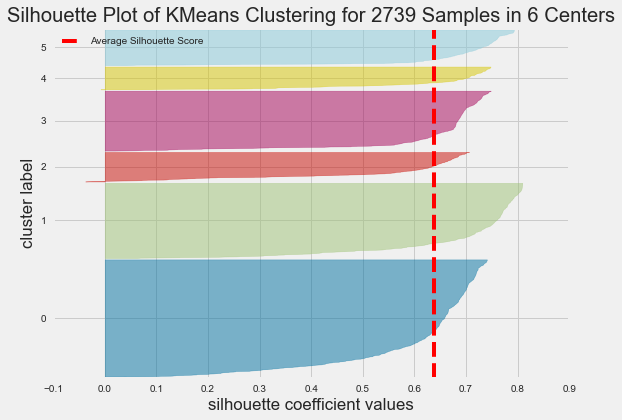

In [34]:
for i in [2,5,6]:
    plt.style.use("fivethirtyeight")
    model = KMeans(n_clusters=i  ,init= "k-means++",n_init=100,random_state=1)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    
    visualizer.fit(X)
    plt.tight_layout()
    visualizer.show()
    

<p/><font color ="green"><b>In the Silhoutte Visualizer we can see that for k=2 and k=3 the instances are distributed unevenly but for k=6 the instances are distributed evenly.</p>
<font color ="green"><b>Therefore, We are Considering number of cluster = 6 for our model.

<h3/>KMeans Clustering: </h3>

In [35]:
kmeans= KMeans(n_clusters = 6, 
                   init = 'k-means++',
                   max_iter = 100,
                   n_init=100,
                   random_state=2)
labels_kmeans=kmeans.fit_predict(X)
pd.Series(labels_kmeans).value_counts()

5    942
1    605
2    482
3    288
0    238
4    184
dtype: int64

In [36]:
df_host["Label_Kmeans"] =  labels_kmeans

Text(0.5, 0, 'Hosting Score')

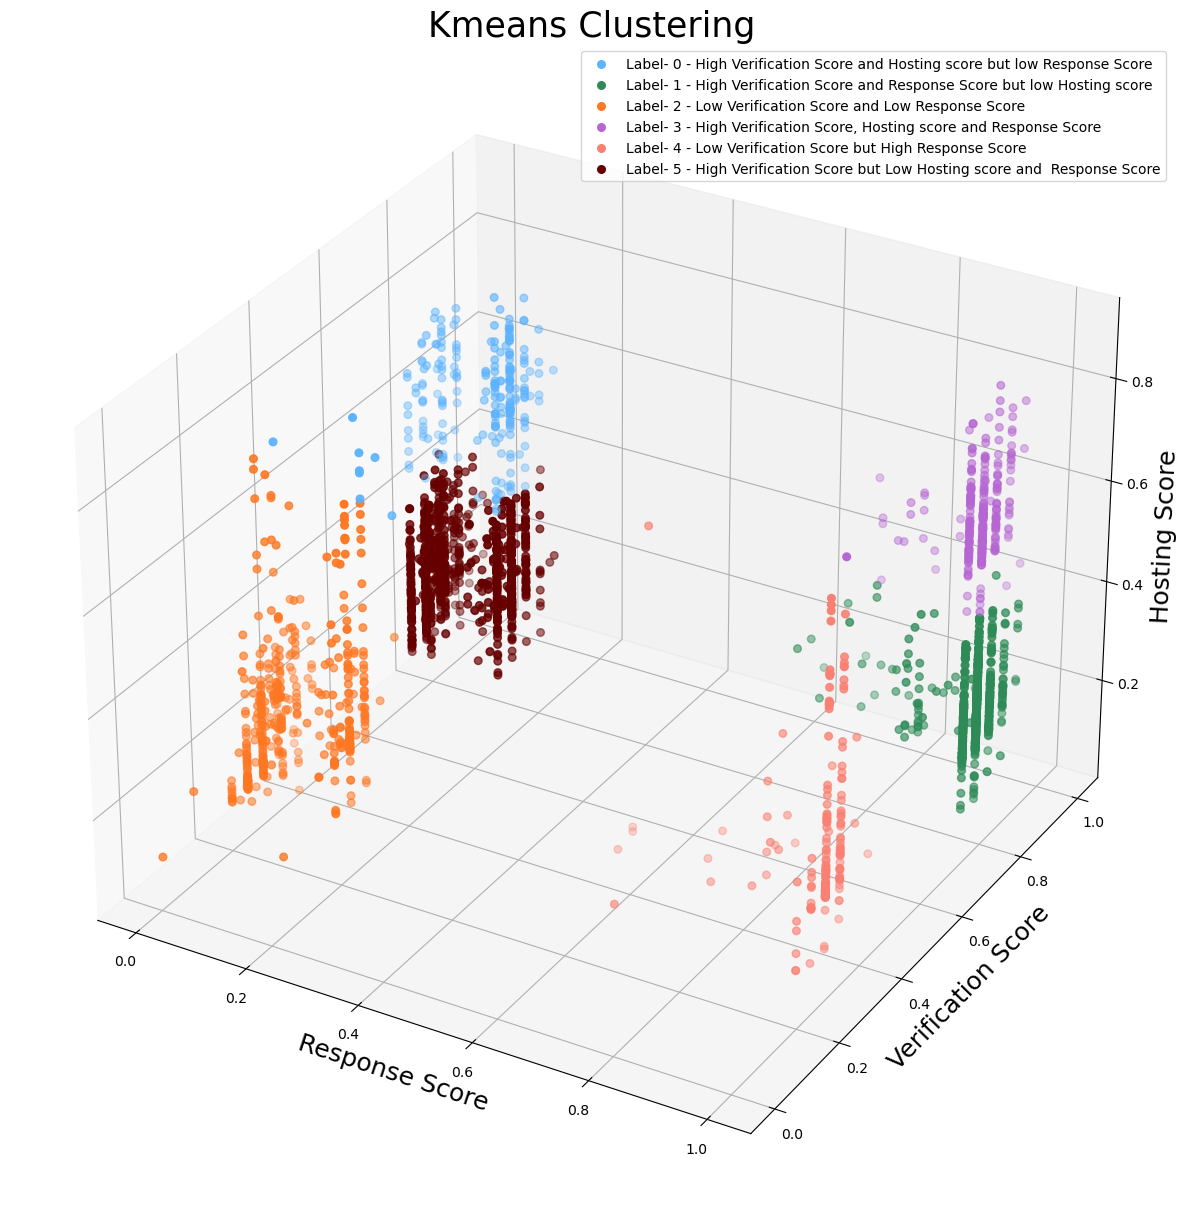

In [37]:
plt.style.use("default")
fig = plt.figure(figsize = (15,20))
ax = plt.axes(projection ="3d")
ax.scatter3D(df_host[df_host.Label_Kmeans==0].Response_score, df_host[df_host.Label_Kmeans==0].verification_score, df_host[df_host.Label_Kmeans==0].Hosting_Score,c="#5CB3FF",s=30)

ax.scatter3D(df_host[df_host.Label_Kmeans==1].Response_score, df_host[df_host.Label_Kmeans==1].verification_score, df_host[df_host.Label_Kmeans==1].Hosting_Score,c="#2E8B57",s=30,)

ax.scatter3D(df_host[df_host.Label_Kmeans==2].Response_score, df_host[df_host.Label_Kmeans==2].verification_score, df_host[df_host.Label_Kmeans==2].Hosting_Score,c="#FF7722",s=30,)

ax.scatter3D(df_host[df_host.Label_Kmeans==3].Response_score, df_host[df_host.Label_Kmeans==3].verification_score, df_host[df_host.Label_Kmeans==3].Hosting_Score,c="#B666D2",s=30,)

ax.scatter3D(df_host[df_host.Label_Kmeans==4].Response_score, df_host[df_host.Label_Kmeans==4].verification_score, df_host[df_host.Label_Kmeans==4].Hosting_Score,c="#FA8072",s=30,)

ax.scatter3D(df_host[df_host.Label_Kmeans==5].Response_score, df_host[df_host.Label_Kmeans==5].verification_score, df_host[df_host.Label_Kmeans==5].Hosting_Score,c="#660000",s=30,)

labels=["Label- 0 - High Verification Score and Hosting score but low Response Score",
"Label- 1 - High Verification Score and Response Score but low Hosting score",
"Label- 2 - Low Verification Score and Low Response Score",
"Label- 3 - High Verification Score, Hosting score and Response Score",
"Label- 4 - Low Verification Score but High Response Score",
"Label- 5 - High Verification Score but Low Hosting score and  Response Score"]

plt.legend(labels,loc="best")
ax.set_title("Kmeans Clustering",size=25)
ax.set_xlabel("Response Score",size=18)
ax.set_ylabel("Verification Score",size=18)
ax.set_zlabel("Hosting Score",size=18)

<h5>Agglomerative Clustering

In [38]:
Agg = AgglomerativeClustering(n_clusters=6, linkage = 'ward')
labels_agg= Agg.fit_predict(df_host[["Response_score", "verification_score", "Hosting_Score"]])
df_host["Label_Agg"]= labels_agg

Text(0.5, 0, 'Hosting Score')

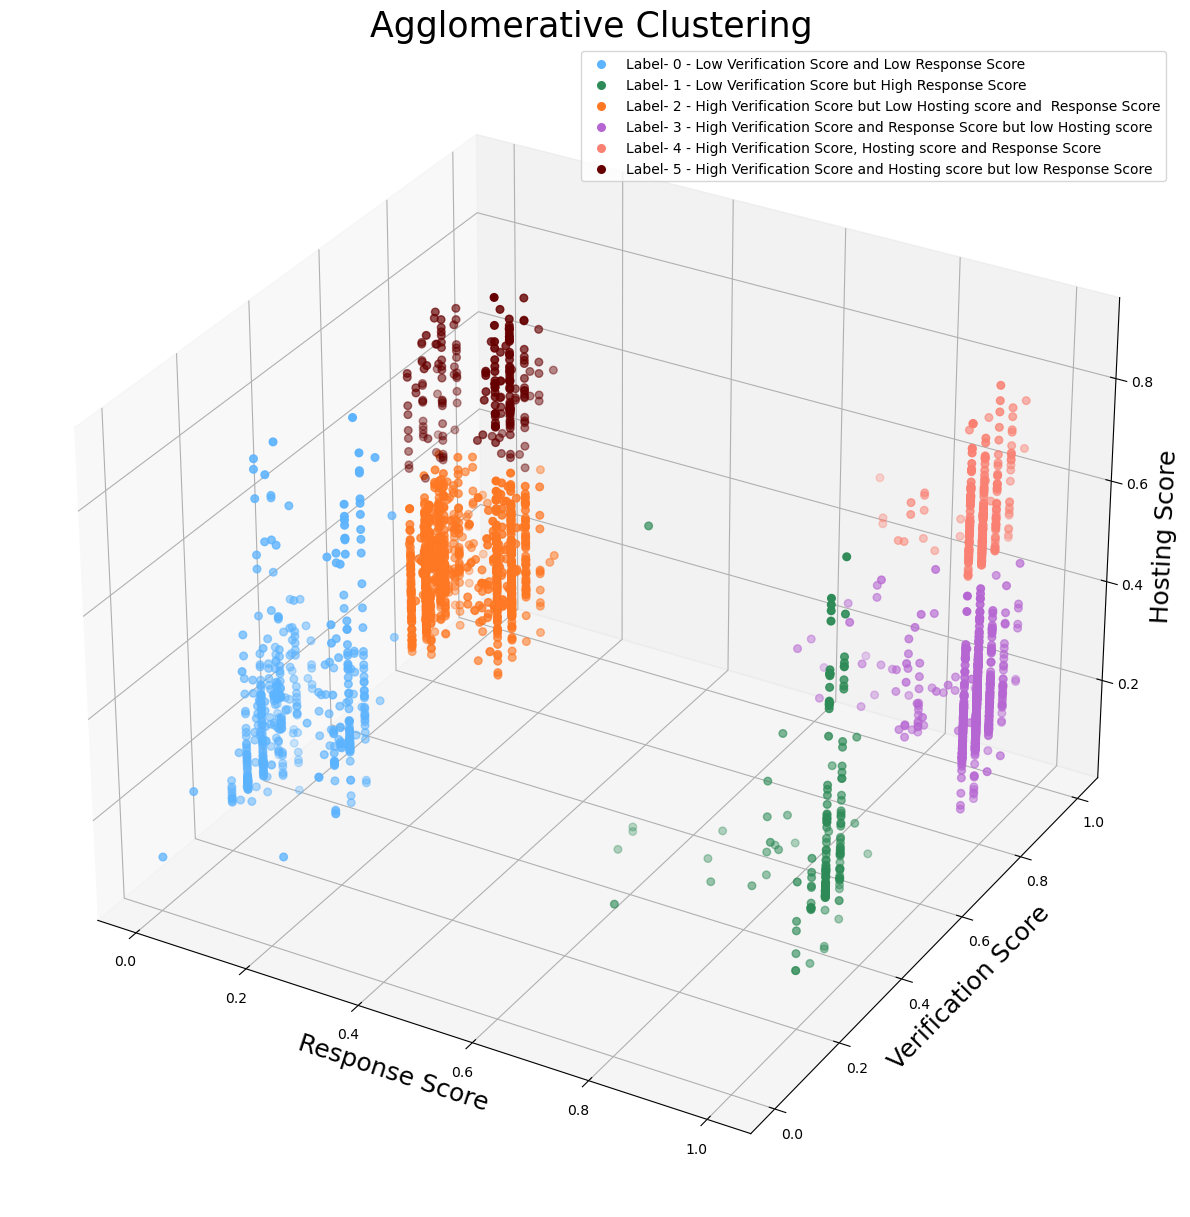

In [39]:
fig = plt.figure(figsize = (15,20))
ax = plt.axes(projection ="3d")

ax.scatter3D(df_host[df_host.Label_Agg==0].Response_score, df_host[df_host.Label_Agg==0].verification_score, df_host[df_host.Label_Agg==0].Hosting_Score,c="#5CB3FF",s=30)

ax.scatter3D(df_host[df_host.Label_Agg==1].Response_score, df_host[df_host.Label_Agg==1].verification_score, df_host[df_host.Label_Agg==1].Hosting_Score,c="#2E8B57",s=30,)

ax.scatter3D(df_host[df_host.Label_Agg==2].Response_score, df_host[df_host.Label_Agg==2].verification_score, df_host[df_host.Label_Agg==2].Hosting_Score,c="#FF7722",s=30,)

ax.scatter3D(df_host[df_host.Label_Agg==3].Response_score, df_host[df_host.Label_Agg==3].verification_score, df_host[df_host.Label_Agg==3].Hosting_Score,c="#B666D2",s=30,)

ax.scatter3D(df_host[df_host.Label_Agg==4].Response_score, df_host[df_host.Label_Agg==4].verification_score, df_host[df_host.Label_Agg==4].Hosting_Score,c="#FA8072",s=30,)

ax.scatter3D(df_host[df_host.Label_Agg==5].Response_score, df_host[df_host.Label_Agg==5].verification_score, df_host[df_host.Label_Agg==5].Hosting_Score,c="#660000",s=30,)

labels=["Label- 0 - Low Verification Score and Low Response Score",
"Label- 1 - Low Verification Score but High Response Score",
"Label- 2 - High Verification Score but Low Hosting score and  Response Score",
"Label- 3 - High Verification Score and Response Score but low Hosting score",
"Label- 4 - High Verification Score, Hosting score and Response Score",
"Label- 5 - High Verification Score and Hosting score but low Response Score"]

plt.legend(labels,loc="best")
ax.set_title("Agglomerative Clustering",size=25)
ax.set_xlabel("Response Score",size=18)
ax.set_ylabel("Verification Score",size=18)
ax.set_zlabel("Hosting Score",size=18)

<h5> DBSCAN Clustering

In [40]:
e= np.linspace(0.02,0.2,25)
s = [10,15,20,25]
for i in e:
    for j in s:
        dbscan= DBSCAN(eps=i,min_samples=j)
        print (f"For ep= {i} and min_samples = {j}\n The labesls are : {np.unique(dbscan.fit_predict(X))}","\nOutliers percentage= ",round(100*(len(X)-len(dbscan.core_sample_indices_))/len(X),2),"%\n")

For ep= 0.02 and min_samples = 10
 The labesls are : [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34] 
Outliers percentage=  43.52 %

For ep= 0.02 and min_samples = 15
 The labesls are : [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] 
Outliers percentage=  57.14 %

For ep= 0.02 and min_samples = 20
 The labesls are : [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Outliers percentage=  63.93 %

For ep= 0.02 and min_samples = 25
 The labesls are : [-1  0  1  2  3  4  5  6  7  8  9 10 11 12] 
Outliers percentage=  70.14 %

For ep= 0.0275 and min_samples = 10
 The labesls are : [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24] 
Outliers percentage=  32.06 %

For ep= 0.0275 and min_samples = 15
 The labesls are : [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] 
Outliers percentage=  44.58 %

For ep= 0.0275 and min_samples = 20
 The labesls are : [-1

For ep= 0.14 and min_samples = 25
 The labesls are : [-1  0  1  2  3] 
Outliers percentage=  2.63 %

For ep= 0.1475 and min_samples = 10
 The labesls are : [-1  0  1  2  3] 
Outliers percentage=  0.51 %

For ep= 0.1475 and min_samples = 15
 The labesls are : [-1  0  1  2  3] 
Outliers percentage=  1.1 %

For ep= 0.1475 and min_samples = 20
 The labesls are : [-1  0  1  2  3] 
Outliers percentage=  1.57 %

For ep= 0.1475 and min_samples = 25
 The labesls are : [-1  0  1  2  3] 
Outliers percentage=  2.12 %

For ep= 0.155 and min_samples = 10
 The labesls are : [-1  0  1  2  3] 
Outliers percentage=  0.4 %

For ep= 0.155 and min_samples = 15
 The labesls are : [-1  0  1  2  3] 
Outliers percentage=  0.8 %

For ep= 0.155 and min_samples = 20
 The labesls are : [-1  0  1  2  3] 
Outliers percentage=  1.35 %

For ep= 0.155 and min_samples = 25
 The labesls are : [-1  0  1  2  3] 
Outliers percentage=  1.57 %

For ep= 0.1625 and min_samples = 10
 The labesls are : [-1  0  1  2  3] 
Outliers 

<h5>If we consider epsilon value 0.1 and minimum samples size =20

In [41]:
dbscan = DBSCAN(eps=0.1,min_samples=20)
labels_dbscan= dbscan.fit_predict(X)

In [42]:
df_host["Label_DBSCAN"] = labels_dbscan

In [43]:
pd.Series(labels_dbscan).value_counts().sort_values()

 5      21
 4      22
-1      45
 3     150
 2     451
 1     879
 0    1171
dtype: int64

<h5>There are 1.46% of outliers and that will give better performance in the boundary.

Text(0.5, 0, 'Hosting Score')

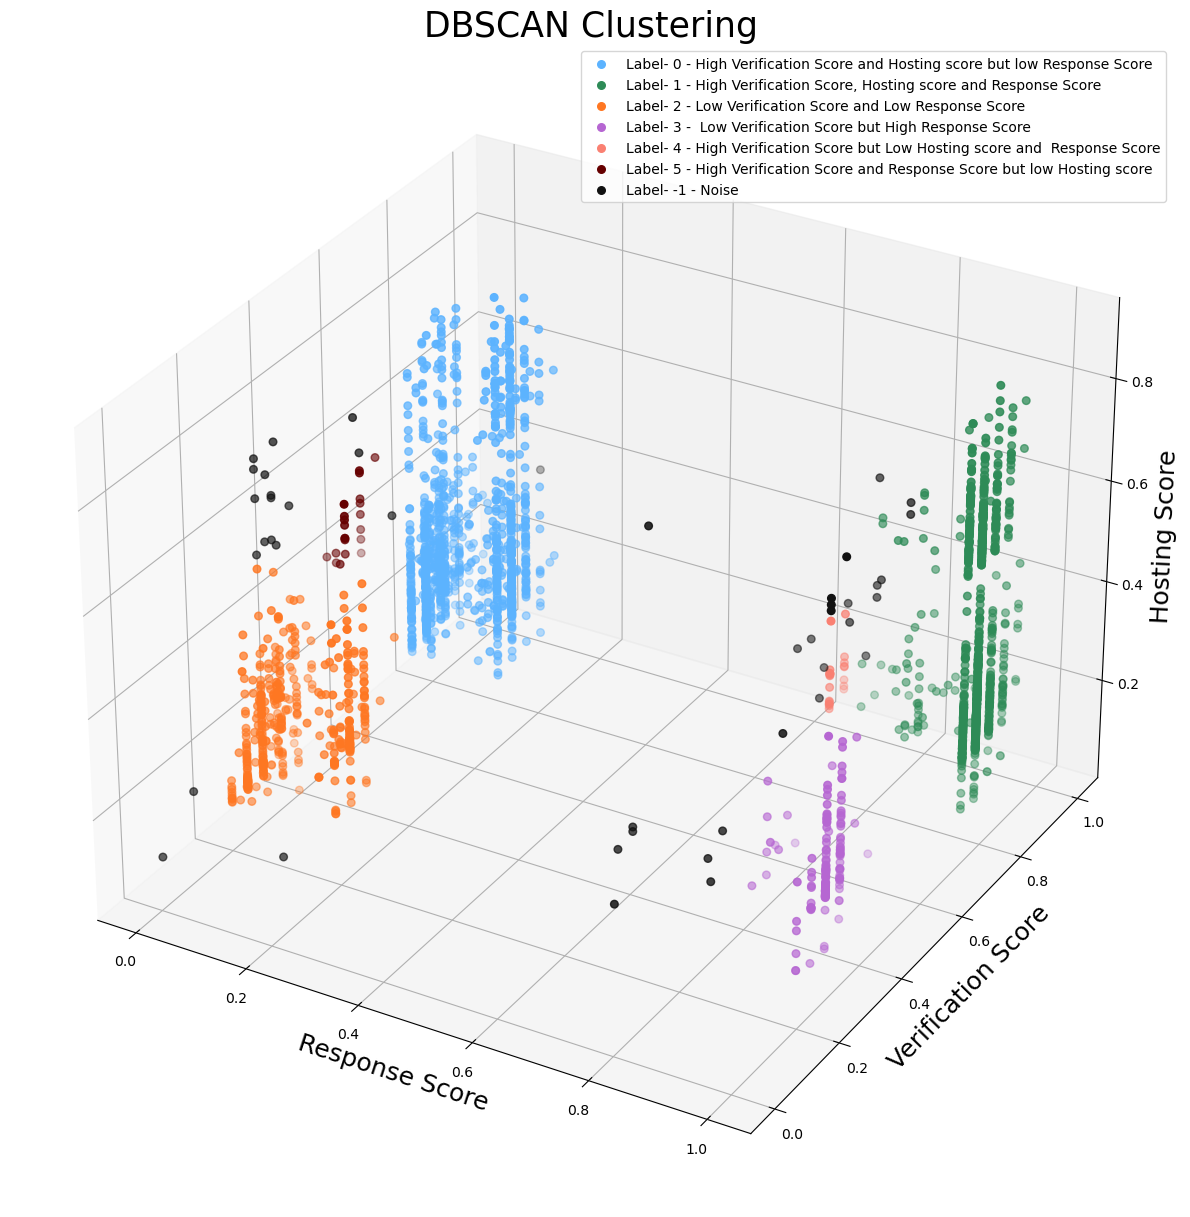

In [44]:
fig = plt.figure(figsize = (15,20))
ax = plt.axes(projection ="3d")

ax.scatter3D(df_host[df_host.Label_DBSCAN==0].Response_score,df_host[df_host.Label_DBSCAN==0].verification_score, df_host[df_host.Label_DBSCAN==0].Hosting_Score,c="#5CB3FF",s=30)

ax.scatter3D(df_host[df_host.Label_DBSCAN==1].Response_score, df_host[df_host.Label_DBSCAN==1].verification_score, df_host[df_host.Label_DBSCAN==1].Hosting_Score,c="#2E8B57",s=30,)

ax.scatter3D(df_host[df_host.Label_DBSCAN==2].Response_score, df_host[df_host.Label_DBSCAN==2].verification_score, df_host[df_host.Label_DBSCAN==2].Hosting_Score,c="#FF7722",s=30,)

ax.scatter3D(df_host[df_host.Label_DBSCAN==3].Response_score, df_host[df_host.Label_DBSCAN==3].verification_score, df_host[df_host.Label_DBSCAN==3].Hosting_Score,c="#B666D2",s=30,)

ax.scatter3D(df_host[df_host.Label_DBSCAN==4].Response_score, df_host[df_host.Label_DBSCAN==4].verification_score,df_host[df_host.Label_DBSCAN==4].Hosting_Score,c="#FA8072",s=30,)

ax.scatter3D(df_host[df_host.Label_DBSCAN==5].Response_score, df_host[df_host.Label_DBSCAN==5].verification_score, df_host[df_host.Label_DBSCAN==5].Hosting_Score,c="#660000",s=30,)

ax.scatter3D(df_host[df_host.Label_DBSCAN==-1].Response_score, df_host[df_host.Label_DBSCAN==-1].verification_score, df_host[df_host.Label_DBSCAN==-1].Hosting_Score,c="k",s=30,)

labels=["Label- 0 - High Verification Score and Hosting score but low Response Score",
"Label- 1 - High Verification Score, Hosting score and Response Score",
"Label- 2 - Low Verification Score and Low Response Score",
"Label- 3 -  Low Verification Score but High Response Score",
"Label- 4 - High Verification Score but Low Hosting score and  Response Score",
"Label- 5 - High Verification Score and Response Score but low Hosting score",
"Label- -1 - Noise" ]

plt.legend(labels,loc="best")
ax.set_title("DBSCAN Clustering",size=25)
ax.set_xlabel("Response Score",size=18)
ax.set_ylabel("Verification Score",size=18)
ax.set_zlabel("Hosting Score",size=18)

<h6>HDBSCAN

In [45]:
c=range(20,100,5)
for i in c:
    model_hdbscan= hdbscan.HDBSCAN(min_cluster_size=i)
    print ("For min cluster size =",i,"\n The labesls are :",np.unique(model_hdbscan.fit_predict(X)))
    if -1 in list(pd.Series(model_hdbscan.fit_predict(X)).value_counts().keys()): 
        print("Number of outlier : ", (pd.Series(model_hdbscan.fit_predict(X)).value_counts()[-1]))
    else:
        print("Number of outlier : ",0)

For min cluster size = 20 
 The labesls are : [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Number of outlier :  839
For min cluster size = 25 
 The labesls are : [-1  0  1  2  3  4  5  6  7]
Number of outlier :  287
For min cluster size = 30 
 The labesls are : [-1  0  1  2  3  4  5  6  7]
Number of outlier :  325
For min cluster size = 35 
 The labesls are : [-1  0  1  2  3  4  5  6]
Number of outlier :  233
For min cluster size = 40 
 The labesls are : [-1  0  1  2  3  4  5  6]
Number of outlier :  268
For min cluster size = 45 
 The labesls are : [-1  0  1  2  3  4  5]
Number of outlier :  326
For min cluster size = 50 
 The labesls are : [-1  0  1  2  3  4]
Number of outlier :  115
For min cluster size = 55 
 The labesls are : [-1  0  1  2  3  4]
Number of outlier :  113
For min cluster size = 60 
 The labesls are : [-1  0  1  2  3  4]
Number of outlier :  156
For min cluster size = 65 
 The labesls are : [-1  0  1  2  3  4]
Number of outlier :  104
For

<h6>Lets take min_cluster_size = 60 to model HDBSCAN

In [46]:
model_hdbscan = hdbscan.HDBSCAN(min_cluster_size=65)
labels_hdbscan = model_hdbscan.fit_predict(X)
pd.Series(labels_hdbscan).value_counts()

 2    1172
 4     564
 1     480
 3     241
 0     178
-1     104
dtype: int64

In [47]:
df_host["Label_HDBSCAN"] = labels_hdbscan

Text(0.5, 0, 'Hosting Score')

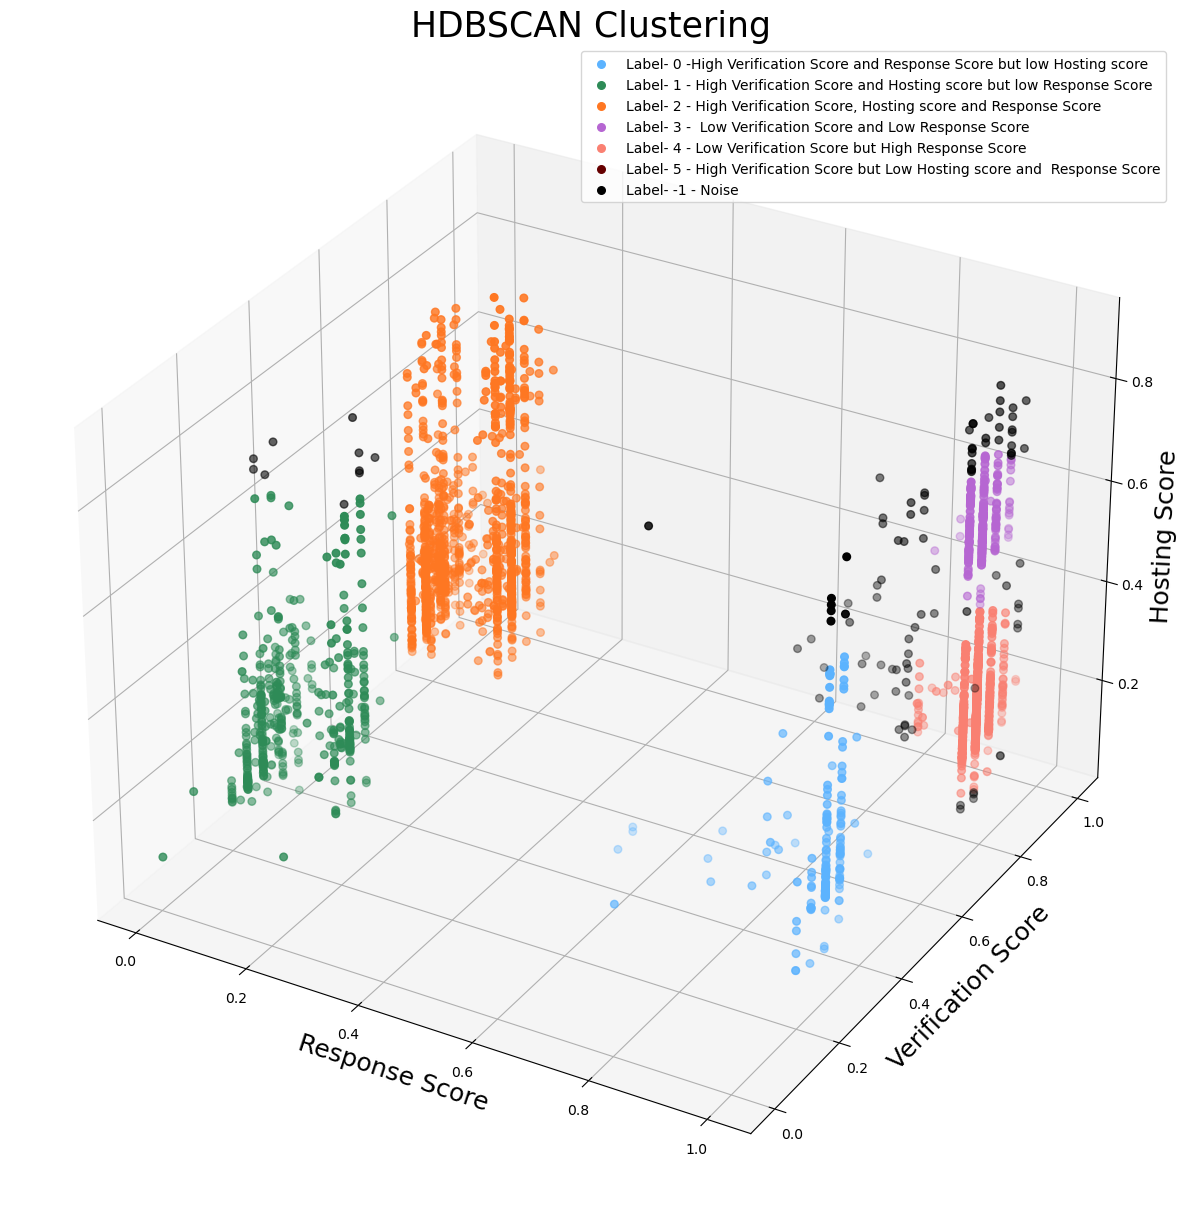

In [48]:
fig = plt.figure(figsize = (15,20))
ax = plt.axes(projection ="3d")

ax.scatter3D(df_host[df_host.Label_HDBSCAN==0].Response_score, df_host[df_host.Label_HDBSCAN==0].verification_score, df_host[df_host.Label_HDBSCAN==0].Hosting_Score,c="#5CB3FF",s=30)

ax.scatter3D(df_host[df_host.Label_HDBSCAN==1].Response_score, df_host[df_host.Label_HDBSCAN==1].verification_score, df_host[df_host.Label_HDBSCAN==1].Hosting_Score,c="#2E8B57",s=30,)

ax.scatter3D(df_host[df_host.Label_HDBSCAN==2].Response_score, df_host[df_host.Label_HDBSCAN==2].verification_score, df_host[df_host.Label_HDBSCAN==2].Hosting_Score,c="#FF7722",s=30,)

ax.scatter3D(df_host[df_host.Label_HDBSCAN==3].Response_score, df_host[df_host.Label_HDBSCAN==3].verification_score, df_host[df_host.Label_HDBSCAN==3].Hosting_Score,c="#B666D2",s=30,)

ax.scatter3D(df_host[df_host.Label_HDBSCAN==4].Response_score, df_host[df_host.Label_HDBSCAN==4].verification_score, df_host[df_host.Label_HDBSCAN==4].Hosting_Score,c="#FA8072",s=30,)

ax.scatter3D(df_host[df_host.Label_HDBSCAN==5].Response_score, df_host[df_host.Label_HDBSCAN==5].verification_score, df_host[df_host.Label_HDBSCAN==5].Hosting_Score,c="#660000",s=30,)

ax.scatter3D(df_host[df_host.Label_HDBSCAN==-1].Response_score, df_host[df_host.Label_HDBSCAN==-1].verification_score, df_host[df_host.Label_HDBSCAN==-1].Hosting_Score,c="#000000",s=30,)

labels=["Label- 0 -High Verification Score and Response Score but low Hosting score",
"Label- 1 - High Verification Score and Hosting score but low Response Score",
"Label- 2 - High Verification Score, Hosting score and Response Score",
"Label- 3 -  Low Verification Score and Low Response Score",
"Label- 4 - Low Verification Score but High Response Score",
"Label- 5 - High Verification Score but Low Hosting score and  Response Score",
"Label- -1 - Noise" ]

plt.legend(labels,loc="best")
ax.set_title("HDBSCAN Clustering",size=25)
ax.set_xlabel("Response Score",size=18)
ax.set_ylabel("Verification Score",size=18)
ax.set_zlabel("Hosting Score",size=18)

<h5>Comparison of all the models:

1. DBSCAN model is giving 45 outliers and also the size of label 4 and label 5 clusters are very less comparative to others, resulting an imbalance model.
2. HDBSCAN model is not treating outliers properly. Also it is not clustering the data cleanly.
3. With KMeans and Agglomerative there are no dataloss due to Outliers and clusters are also neat. As agglomeratuve clustering behaves better in the boundary we are considering Agglemerative model as our final model.

<h3>Final Model: Agglomerative Clustering

In [49]:
df_host=df_host.drop(["Label_Kmeans","Label_DBSCAN","Label_HDBSCAN","Label_Agg"],axis=1)

In [50]:
Agg = AgglomerativeClustering(n_clusters=6, linkage = 'ward')
labels_agg= Agg.fit_predict(X)
df_host["Label"]= labels_agg

In [57]:
fig=px.scatter_3d(df_host, x='Response_score', y='verification_score', z='Hosting_Score',color="Label",height=600)
fig.show()

In [52]:
df_host.head()

index  host_id  hosting_experience  host_response_time  host_response_rate  \
0   2180     4193                2611                   6                0.88   
1   1405     6207                2552                   1                1.00   
2   3005     8021                2513                   6                0.75   
3   2155     8993                2498                   1                1.00   
4   2230    11775                2471                   6                1.00   

   host_acceptance_rate  host_is_superhost  host_verifications  \
0                   1.0                  0                   5   
1                   1.0                  1                   6   
2                   1.0                  0                   6   
3                   1.0                  0                   4   
4                   1.0                  0                   5   

   host_has_profile_pic  host_identity_verified  \
0                     1                       1   
1                     1                       1   
2                     1                       1   
3                     1                       1   
4                     1                       1   

   calculated_host_listings_count cancellation_policy  review_scores_rating_y  \
0                               4              strict                0.896667   
1                               1              strict                0.960000   
2                               1            flexible                0.965000   
3                               1              strict                0.960000   
4                               1            moderate                0.950000   

   Response_score  verification_score  Hosting_Score  Label  
0        0.146667               0.775       0.560811      5  
1        1.000000               0.820       0.894794      4  
2        0.125000               0.820       0.539566      5  
3        1.000000               0.730       0.537555      3  
4        0.166667               0.775       0.533936      5

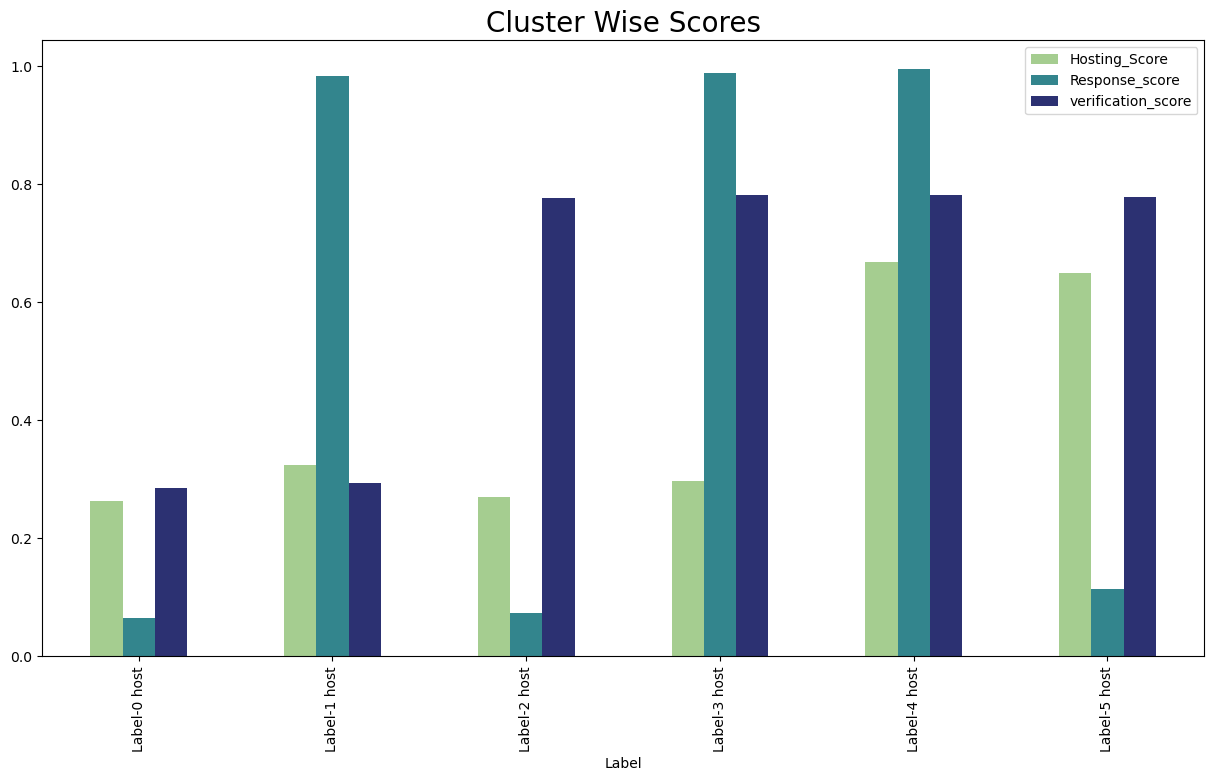

In [53]:
ax=pd.pivot_table(data= df_host,index="Label",values=["Response_score","Hosting_Score","verification_score"]).plot(kind="bar",figsize=(15,8),colormap='crest')
ax.set_xticklabels(["Label-0 host","Label-1 host","Label-2 host","Label-3 host","Label-4 host","Label-5 host",])
ax.legend(loc="best")
ax.set_title("Cluster Wise Scores",size=20)
plt.show()

<li><b/>Label- 0 </b>- Hosts who are neither properly verified nor having good response record.
<li><b/>Label- 1 </b>- Hosts who are not properly verified but have good response record.
<li><b/>Label- 2 </b>- Hosts who are neither possesses good response record nor good hosting record but verified properly.
<li><b/>Label- 3 </b>- Highly verified and also having quick rensponse record but low hosting quality
<li><b/>Label- 4 </b>- Highly verified and also having quick rensponse record and high hosting quality
<li><b/>Label- 5 </b>- Highly verified but less hosting quality

<li><b/>Label- 0 </b>- Inactive Hosts
<li><b/>Label- 1 </b>- Hosts who are not properly verified but have good response record.
<li><b/>Label- 2 </b>- Hosts who are neither possesses good response record nor good hosting record but verified properly.
<li><b/>Label- 3 </b>- Highly verified and also having quick rensponse record but low hosting quality
<li><b/>Label- 4 </b>- Highly verified and also having quick rensponse record and high hosting quality
<li><b/>Label- 5 </b>- Highly verified but less hosting quality

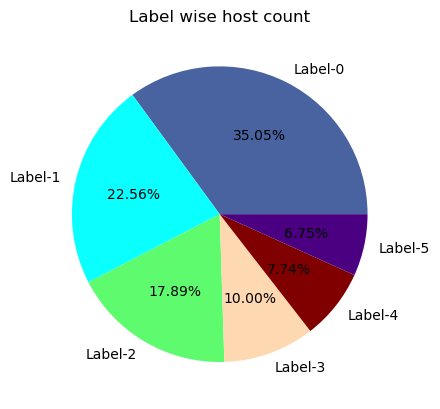

In [55]:
plt.pie(df_host.Label.value_counts(),labels=["Label-0","Label-1","Label-2","Label-3","Label-4","Label-5"],autopct="%.2f%%",colors=["#4863A0","#0AFFFF","#5EFB6E","#FED8B1","#800000","#4B0082"])
plt.title("Label wise host count")
plt.show()

In [ ]:
pd.pivot_table(data= df_host,index="Label",values=["calculated_host_listings_count"],aggfunc="sum")

Inferences:
   1. 35% of the listed hosts are neither properly verified nor having good response record.
   2. Only 7% of the total listed hosts are perfect in terms of verification, responsiveness and Hosting quality
   3. The best hosts(level -4 hosts) have total 386 properties.

In [59]:
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls

In [60]:
api_key="chWxVqf6rSeEVb6gkTU9"
user_name= "kalyanchatterjee84"

In [61]:
chart_studio.tools.set_credentials_file(username=user_name,api_key=api_key)

In [62]:
py.plot(fig,filename="graph",auto_open=False)

'https://plotly.com/~kalyanchatterjee84/1/'